In [353]:
import os
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

In [354]:
class Camera_pose:
    def __init__(self):
        self.name = ""
        self.position = [0, 0, 0]
        self.rotation = [0, 0, 0]

In [355]:
def rotation():
    xyz_mat = [0, 0, 0]
    roll = 90 # x
    pitch = 0 # y
    yaw = 0 # z

    # roll rotate x, pitch rotate y, yaw rotate z
    roll_mat = np.array([[1, 0, 0],
                        [0, math.cos(roll), -(math.sin(roll))],
                        [0, math.sin(roll), math.cos(roll)]
                        ])
    pitch_mat = np.array([[math.cos(pitch), 0, -(math.sin(pitch))],
                        [0, 1, 0],
                        [math.sin(pitch), 0, math.cos(pitch)]
                        ])
    yaw_mat = np.array([[math.cos(yaw), -(math.sin(yaw)), 0],
                        [math.sin(yaw), math.cos(yaw), 0],
                        [0, 0, 1]
                        ])
    rotation_mat = np.dot(np.dot(yaw_mat, pitch_mat), roll_mat)
    result_mat = np.dot(rotation_mat, xyz_mat)
    print(result_mat)

In [356]:
def euler_angles_to_directional_vector(x, y, z, row, pitch, yaw):
    # math cos() and sin() have to insert in unit 'rad'
    # rad = degree * math.pi / 180
    x_dir = math.cos(yaw*math.pi/180)*math.cos(pitch*math.pi/180)
    y_dir = math.sin(yaw*math.pi/180)*math.cos(pitch*math.pi/180)
    z_dir = math.sin(pitch*math.pi/180)
    # print(f'{x_dir}, {y_dir}, {z_dir}')
    return x, y, z, round(x_dir, 4), round(y_dir, 4), round(z_dir, 4)

In [357]:
def project(position, L):
    x, y, z, x_dir, y_dir, z_dir = euler_angles_to_directional_vector(
        position[0], position[1], position[2], position[3], position[4], position[5])
    print(f'x_dir:{x_dir}')
    print(f'y_dir:{y_dir}')
    print(f'z_dir:{z_dir}')
    D = ((L-x)/x_dir)
    new_x = L
    new_y = y + y_dir*D
    new_z = z + z_dir*D
    print(f"({new_x},{new_y},{new_z})")
    return new_x, new_y, new_z


In [358]:
def plot_heatmap():
    pose_traces = [f'pose{i}' for i in range(10)]
    df = pd.DataFrame()
    df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
    df = df.append(df_tmp)
    ax = sns.scatterplot(x='y', y=f'z', hue='pose_traces', data=df_tmp)
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    # plt.savefig(f'./img/siti/siti.eps', dpi=300)
    plt.savefig(f'./test.png', dpi=300)
    plt.show()

    for pose_trace in pose_traces:
        print(pose_trace)
        df_tmp = df.loc[(df['pose_traces'] == pose_trace)]

        ax = sns.kdeplot(x='y', y=f'z', data=df_tmp, fill="True")
        plt.xlim((-15,15))
        plt.ylim((-15,15))
        # plt.savefig(f'./img/siti/siti.eps', dpi=300)
        # plt.savefig(f'./img/siti/siti.png', dpi=300)
        plt.show()


In [359]:
def main():
    L = 10
    pose_traces = [f'pose{i}' for i in range(10)]
    datas = []
    all_datas = []
    # datas.append(['x', 'y', 'z'])
    for pose_trace in pose_traces:
        # read file
        df = pd.read_csv(f'./random_trace_original/{pose_trace}.csv')
        for index in df.index:
            position = [df.loc[index]['x'], df.loc[index]['y'], df.loc[index]['z'], df.loc[index]['roll'], df.loc[index]['pitch'], df.loc[index]['yaw']]
            project_x, project_y, project_z = project(position, L)
            datas.append([project_x, project_y, project_z])
            all_datas.append([pose_trace, project_x, project_y, project_z])
        pd.DataFrame(datas).to_csv(f'./project_results/{pose_trace}.csv',index=False,float_format='{:f}'.format,header=['x', 'y', 'z'], encoding='utf-8')
    pd.DataFrame(all_datas).to_csv(f'./project_results/all_pose_trace.csv',index=False,float_format='{:f}'.format,header=['pose_traces', 'x', 'y', 'z'], encoding='utf-8')
    

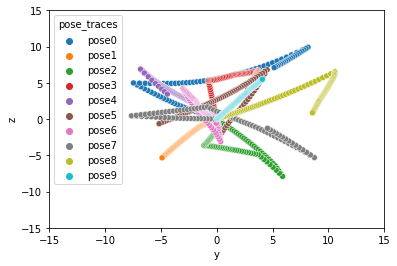

pose0


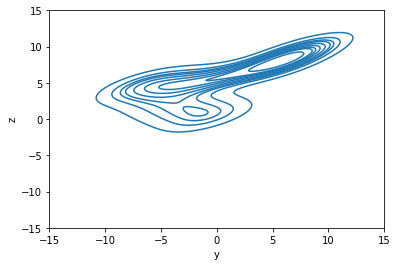

pose1


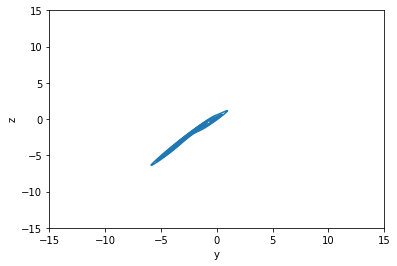

pose2


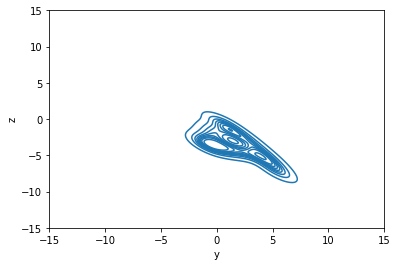

pose3


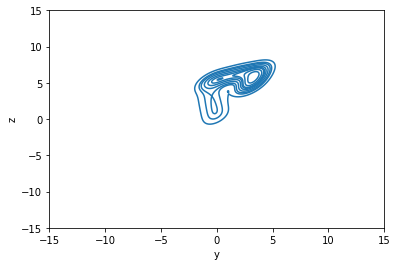

pose4


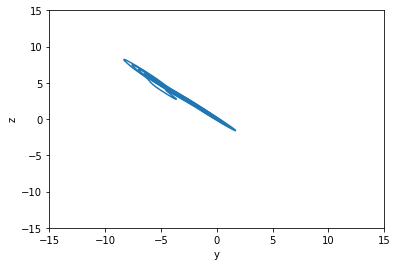

pose5


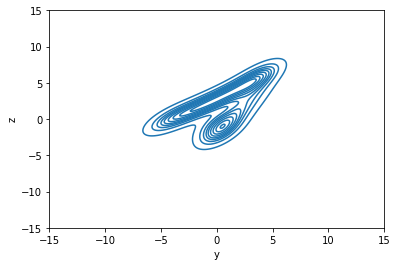

pose6


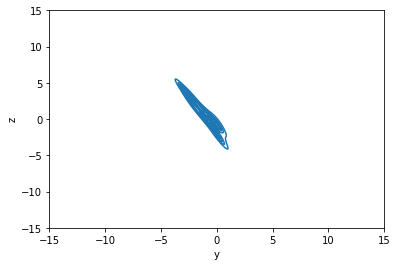

pose7


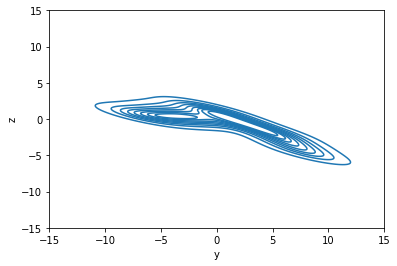

pose8


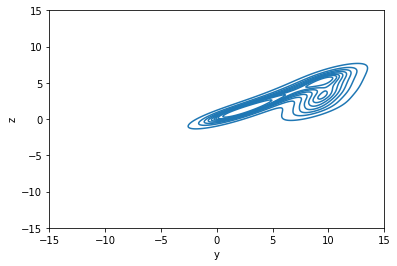

pose9


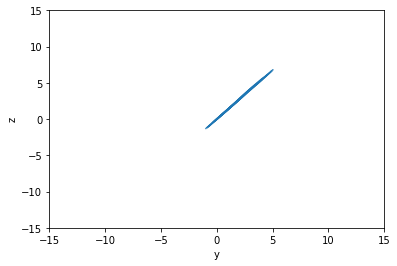

In [360]:
if __name__ == '__main__':
    # main()
    plot_heatmap()